<a href="https://colab.research.google.com/github/AbhiramNS1/Hate-speech-classifier/blob/main/hate_speech_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Loading dataset

dataset_url = "https://github.com/AbhiramNS1/Hate-speech-classifier/raw/main/dataset/train.zip"
df = pd.read_csv(dataset_url)
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


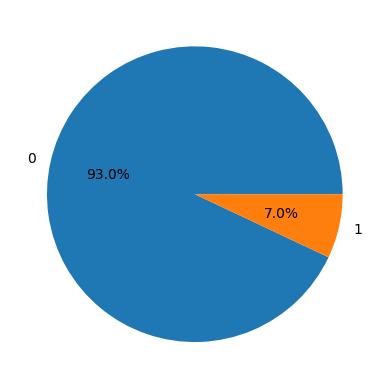

In [10]:
# Visualizing the dataset
from matplotlib import pyplot as plt

plt.pie(df['label'].value_counts().values,
        labels = df['label'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [30]:
# preproessing data
import string
def remove_punctation(text):
  temp = str.maketrans('', '', string.punctuation)
  return text.translate(temp)


df["tweet"] = df["tweet"].apply(lambda x: remove_punctation(x))

In [24]:
df["tweet"] = df["tweet"].str.lower()
df.head()

,id,label,tweet
0,1,0,user when a father is dysfunctional and is so...
1,2,0,user user thanks for lyft credit i cant use ca...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in u...
4,5,0,factsguide society now motivation


In [28]:
# Lemmatizing the word
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def remove_stopwords_and_lemmatize(text):
  imp_words = []
  for word in text.split():
    if word not in stop_words:
      lemmatizer.lemmatize(word)
      imp_words.append(word)
  return " ".join(imp_words)


df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords_and_lemmatize(text))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,label,tweet
0,1,0,user father dysfunctional selfish drags kids d...
1,2,0,user user thanks lyft credit cant use cause do...
2,3,0,bihday majesty
3,4,0,model love u take u time urð± ðððð...
4,5,0,factsguide society motivation


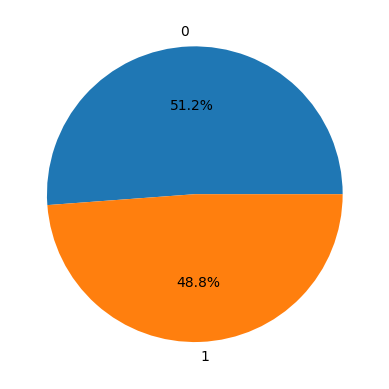

In [49]:
# Equalizing the class imbalance
class_0 = df[df['label']==0].sample(4700)
class_1 = df[df['label']==1]

balanced_df = pd.concat([class_0,class_1,class_1],axis=0)

plt.pie(balanced_df['label'].value_counts().values,
		labels=balanced_df['label'].value_counts().index,
		autopct='%1.1f%%')
plt.show()


In [81]:
# splitting to training and testing set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(balanced_df["tweet"],balanced_df["label"],test_size=0.2,random_state=40)

X_train.shape , X_test.shape

((7347,), (1837,))

In [82]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_train.shape, y_test.shape

((7347, 2), (1837, 2))

In [83]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000,lower=True,split=" ")
tokenizer.fit_on_texts(X_train)


In [84]:
from keras.preprocessing.sequence import pad_sequences

max_words=50

training_sequences = tokenizer.texts_to_sequences(X_train)
training_dataset = pad_sequences(training_sequences,maxlen=max_words,truncating='post',padding='post')

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_dataset = pad_sequences(testing_sequences,maxlen=max_words,truncating='post',padding='post')

In [86]:
print(y_test)

           0      1
17726   True  False
10319  False   True
19868   True  False
11555   True  False
21940  False   True
...      ...    ...
11187   True  False
29087  False   True
29911  False   True
3594    True  False
26140   True  False

[1837 rows x 2 columns]


In [87]:
from keras import models,layers,utils
model = models.Sequential([
	layers.Embedding(5000, 32, input_length=50),
	layers.Bidirectional(layers.LSTM(16)),
	layers.Dense(512, activation='relu', kernel_regularizer='l1'),
	layers.BatchNormalization(),
	layers.Dropout(0.3),
	layers.Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
			optimizer='adam',
			metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 32)            160000    
                                                                 
 bidirectional_5 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 512)               16896     
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                

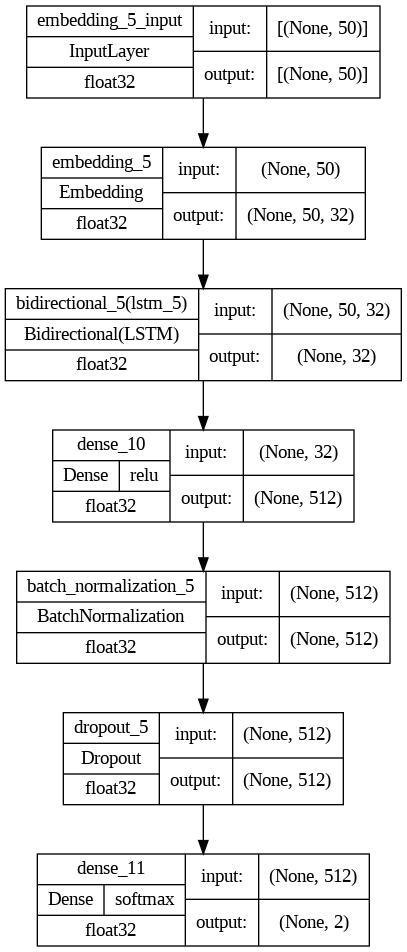

In [88]:
utils.plot_model(
	model,
	show_shapes=True,
	show_dtype=True,
	show_layer_activations=True
)


In [89]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


In [91]:
history = model.fit(training_dataset, y_train,
					validation_data=(testing_dataset, y_test),
					epochs=50,
					verbose=1,
					batch_size=32,
					callbacks=[lr, es])


Epoch 1/50
230/230 [==============================] - 9s 29ms/step - loss: 1.7871 - accuracy: 0.8435 - val_loss: 0.6203 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 2/50
230/230 [==============================] - 5s 20ms/step - loss: 0.2060 - accuracy: 0.9435 - val_loss: 0.3910 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 3/50
230/230 [==============================] - 6s 25ms/step - loss: 0.1300 - accuracy: 0.9696 - val_loss: 0.2845 - val_accuracy: 0.9129 - lr: 0.0010
Epoch 4/50
230/230 [==============================] - 5s 22ms/step - loss: 0.1086 - accuracy: 0.9770 - val_loss: 0.2848 - val_accuracy: 0.9271 - lr: 0.0010
Epoch 5/50
230/230 [==============================] - 5s 21ms/step - loss: 0.0959 - accuracy: 0.9804 - val_loss: 0.2936 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 6/50
230/230 [==============================] - 6s 28ms/step - loss: 0.0570 - accuracy: 0.9897 - val_loss: 0.3102 - val_accuracy: 0.9265 - lr: 5.0000e-04
Epoch 7/50
230/230 [==============================] - 5s 21m

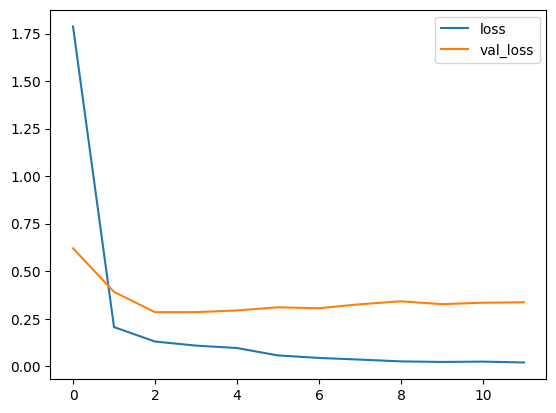

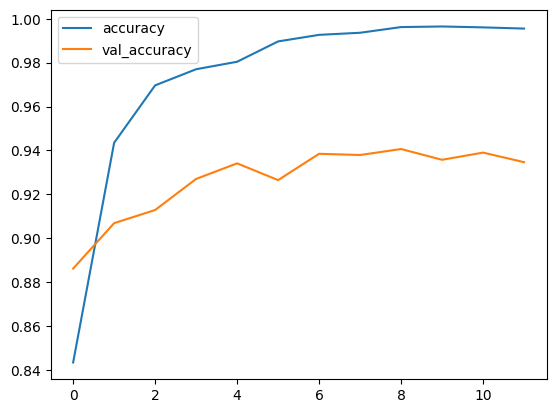

In [92]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()